[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SlimeVRX/SlimeVRX/blob/main/hipnuc/document/11.ipynb)

#**Study [Attitude for IMU & AHRS](https://zhuanlan.zhihu.com/p/351596374)**
#**Lesson 11: Speed and position updates** [(速度及位置更新)](https://zhuanlan.zhihu.com/p/101391544)

Với giải pháp Attitude, 

Nguyên tắc cơ bản: Mối quan hệ giữa gia tốc, vận tốc và vị trí đã học ở trường trung học cơ sở: gia tốc là vi phân của vận tốc và vận tốc là vi phân của vị trí. Gia tốc có thể được đo bằng gia tốc kế, sau đó tích phân gia tốc để có được vận tốc, và tích phân vận tốc để có được vị trí.

<p align="left"><img width="500", src="https://pic1.zhimg.com/80/v2-f7467b9e3e856f42161935b6b904bccc_720w.jpg"></p>

công thức điều hướng quán tính

Trong trường hợp lý tưởng(tất cả các cảm biến không có lỗi):
1. Đầu tiên thực hiện tính toán Attitude, để nhận được Cb2n tại mỗi thời điểm.
2. Truyền giá trị đo gia tốc tại mỗi thời điểm cho hệ n thông qua Cb2n.
3. Trừ trọng lực với giá trị đo gia tốc (lực riêng) trong hệ n để được gia tốc sau khi trừ trọng lực
4. Tích phân gia tốc sau khi loại bỏ trọng lực để có vận tốc
5. Tích phân vận tốc để có vị trí
6. Kết thúc

<p align="left"><img width="1000", src="https://pic1.zhimg.com/v2-63b6f230f997723d690e38d43f72fc04_r.jpg"></p>

Tóm tắt các thuật toán Attitude, trong đó tốc độ và vị trí được giải bằng phương pháp trung vị. Nếu đó là chi phí thấp, ngay cả phương pháp trung vị cũng có thể được bỏ qua và sự khác biệt không lớn.

Nói nhiều quá nên mình hơi bối rối, vào Python và bắt đầu nhé. Dựa trên chức năng cập nhật Attitude Quaternion trước đó, viết một bản cập nhật giải pháp điều hướng quán tính.

In [1]:
import numpy as np
cos = np.cos
sin = np.sin
asin = np.arcsin
atan2 = np.arctan2

In [2]:
from numpy.linalg import norm
def ch_qnormlz(q):
    q = q / norm(q,2)
    if q[0] < 0:
        q[0] = -q[0]
        q[1] = -q[1]
        q[2] = -q[2]
        q[3] = -q[3]
    return q

def ch_rv2q(rv):
    nm2 = rv.dot(rv)
    if nm2 < 1.e-8:
        q0 = 1-nm2*(1/8-nm2/384)
        s = 1/2-nm2*(1/48-nm2/3840)
    else:
        nm = np.sqrt(nm2)
        q0 = cos(nm/2)
        s = sin(nm/2)/nm
    q = np.concatenate([[q0],s*rv])
    return q

def ch_qmul(q1, q2):
    q = np.array([ q1[0] * q2[0] - q1[1] * q2[1] - q1[2] * q2[2] - q1[3] * q2[3],
                   q1[0] * q2[1] + q1[1] * q2[0] + q1[2] * q2[3] - q1[3] * q2[2],
                   q1[0] * q2[2] + q1[2] * q2[0] + q1[3] * q2[1] - q1[1] * q2[3],
                   q1[0] * q2[3] + q1[3] * q2[0] + q1[1] * q2[2] - q1[2] * q2[1] ], dtype=np.float64)
    return q

def ch_att_upt(in_, gyr, dt):
    # Véc tơ quay đơn nguyên
    rv = gyr * dt
    dq = ch_rv2q(rv)
    
    out = ch_qmul(in_, dq)
    out = ch_qnormlz(out)
    return out

In [3]:
def ch_qconj(qin):
    return np.concatenate([[qin[0]], -qin[1:]])

def ch_qmulv(q, vin):
    qi = np.concatenate([[0], vin])
    qo = ch_qmul(ch_qmul(q,qi),ch_qconj(q))
    vout = qo[1:]
    return vout

def ch_nav_equ_local_tan(p, v, q ,acc, gyr, dt, gN):
    # Cập nhật giải pháp điều hướng quán tính, hệ tọa độ Descartes cục bộ, không phụ thuộc vào lực hấp dẫn của Trái đất
    # p vị trí XYZ đơn vị m
    # v tốc độ XYZ đơn vị m/s
    # q Attitude Qb2n, Quaternion
    # acc đối chiếu, Phép đo gia tốc kế đơn vị (m/s^2)
    # gyr vận tốc góc đơn vị (rad/s)
    # dt khoảng thời gian tích phân 0.01s
    # gn véc tơ trọng lực cục bộ
    old_v = v
    sf = acc

    # Attitude ...
    q = ch_att_upt(q, gyr, dt)

    # Giải pháp vận tốc / Velocity
    sf = ch_qmulv(q, sf)
    sf = sf + gN
    v = old_v + dt * sf

    # Giải pháp vị trí
    p = p + (old_v + v) * dt / 2
    return p, v, q

def ch_q2eul_312(Qb2n):
    q0 = Qb2n[0]
    q1 = Qb2n[1]
    q2 = Qb2n[2]
    q3 = Qb2n[3]

    roll = -atan2(2 * (q1 * q3 - q0 * q2), q0 * q0 - q1 * q1 - q2 * q2 + q3 * q3)
    pitch = asin(2 * (q0 * q1 + q2 * q3))
    yaw = -atan2(2 * (q1 * q2 - q0 * q3), q0 * q0 - q1 * q1 + q2 * q2 - q3 * q3)
    return pitch, roll, yaw

Ví dụ 1: Giải pháp điều hướng quán tính tĩnh

Giả sử rằng đối tượng là đứng yên, thì về mặt lý thuyết, Attitude sẽ không thay đổi và kết quả của vị trí cũng không thay đổi, nhưng trong thực tế, cảm biến luôn có sai số và sai lệch bằng 0, vì vậy ngay cả khi nó là tĩnh, nếu bạn lấy dữ liệu cảm biến, không xử lý nó, chỉ cần đưa nó vào Giải pháp điều hướng quán tính, và sau một thời gian, Attitude và vị trí cũng sẽ được bù đắp. Sau đây là một mô phỏng của Python để thể hiện ý tưởng này:

Gyro bias(rad):0.002 0.003 0.005

Plus bias(m/s^(2)):0.000 0.000 9.795

Solving: 1000 times, Total time: 10.000s

Final error (m): 5.743 -2.778 -0.062



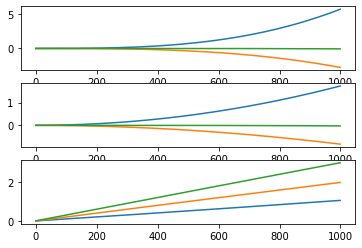

In [5]:
Fs = 100
N = Fs*10

gyr = np.array([0.1, 0.2, 0.3])
acc = np.array([0, 0, 1])

acc = acc * 9.795
gyr = np.deg2rad(gyr)

# Giải pháp Điều hướng Quán tính Strapdown
p = np.zeros((3), dtype=np.float64)   # p = zeros(3, 1);
v = np.zeros((3), dtype=np.float64)   # v = zeros(3, 1);
q = np.array([1, 0, 0, 0])

pos = np.zeros((N, 3), dtype=np.float64)
vel = np.zeros((N, 3), dtype=np.float64)
eul = np.zeros((N, 3), dtype=np.float64)

for i in range(N):
    p ,v, q = ch_nav_equ_local_tan(p, v, q, acc.T, gyr.T, 1/Fs, np.array([0, 0, -9.795]).T)
    pos[i, :] = p
    vel[i, :] = v
    eul[i, :] = np.rad2deg(ch_q2eul_312(q))

# Thử nghiệm tích phân thuần túy: Gyro bias
print('Gyro bias(rad):%.3f %.3f %.3f\n' %(gyr[0], gyr[1], gyr[2]))

# Thử nghiệm tích phân thuần túy: Plus bias
print('Plus bias(m/s^(2)):%.3f %.3f %.3f\n' %(acc[0], acc[1], acc[2]))

print('Solving: %d times, Total time: %.3fs\n' %(N, N /Fs))

print('Final error (m): %.3f %.3f %.3f\n' %(pos[N-1, 0],  pos[N-1, 1],  pos[N-1, 2]))

import matplotlib.pyplot as plt

plt.figure()
plt.subplot(311)
plt.plot(pos)
plt.subplot(312)
plt.plot(vel)
plt.subplot(313)
plt.plot(eul)

Giải thích chương trình này:

gyr =[0.1,0.2,0.3] là đầu ra con quay hồi chuyển trong mô phỏng tĩnh. Về lý thuyết, đầu ra con quay hồi chuyển phải bằng 0 ở trạng thái tĩnh, nhưng thực tế không phải vậy, có một "thiên vị" nào đó. Nói cách khác độ lệch trục X của con quay hồi chuyển = 0,1dps(°/s), trục Y = 0,2dps, trục Z = 0,3dps. Những giá trị này không quá phóng đại đối với một con quay hồi chuyển MEMS có giá hơn mười đô la.

Theo cách tương tự, gia tốc sẽ xuất ra [0, 0, 1G] ở trạng thái tĩnh, (1G là gia tốc trọng trường cục bộ). Đối với chip MEMS thông thường, không có gì ngạc nhiên khi sai số gia tốc kế đạt 1-20mG, qua kết quả mô phỏng có thể thấy rằng **chỉ sau 10s, các sai lệch này có thể gây ra sai số tối đa gần 6 mét. Nếu là 1 phút, có thể gây ra sai số 1000 mét!**

Tóm lại là:
- Giải pháp điều hướng quán tính được chia thành ba bước: cập nhật Attitude, cập nhật tốc độ và cập nhật vị trí. Trong đó, cập nhật Attitude là phức tạp nhất và cập nhật vị trí và tốc độ tương đối đơn giản.
- **Nếu MEMS giá rẻ là dẫn đường quán tính thuần túy, thì sai số tính toán vị trí sẽ bay ra khỏi bầu trời, điều này không có ý nghĩa thực tế.** Các cảm biến khác cung cấp vị trí tuyệt đối (GPS) phải được thêm vào để tổng hợp dữ liệu.
- Giải pháp Attitude -> giải pháp tốc độ -> giải pháp vị trí về bản chất là một quá trình tích phân, do đó phải có giá trị ban đầu và các bài toán sai số tích lũy. Nhiều người hỏi liệu MEMS giá rẻ có thể theo dõi quỹ đạo hoặc thậm chí điều hướng không. Câu trả lời là: về mặt lý thuyết là có, thực tế không. Nói chung, khi khảo sát chuyển động trên mặt đất, sai số tích lũy có thể lên đến hơn mười mét trong vài giây. Nếu bạn giải quyết vấn đề với điều hướng quán tính thuần túy trong 2 phút, ước tính rằng sự khác biệt có thể là vài Km. Các ví dụ trong phần này minh họa vấn đề này một cách sinh động.

Chúng tôi thực sự khuyên bạn nên sửa đổi giá trị độ lệch và thời gian tích phân của con quay hồi chuyển và gia tốc, đồng thời trực quan cảm nhận mức độ ảnh hưởng của lỗi cảm biến đối với giải pháp điều hướng quán tính. Tôi cũng có thể hiểu được ý nghĩa của câu: **"nếu MEMS giá rẻ là dẫn đường quán tính thuần túy thì sai số tính toán vị trí sẽ bay khỏi bầu trời"**. Nhắc lại, giải pháp điều hướng quán tính về bản chất là một quá trình tích phân, điều này chắc chắn sẽ mang lại các lỗi tích lũy và các lỗi sẽ phân kỳ theo thời gian.